## Self supervised large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised/train.json"

s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-bert-f1-2022-10-09-23-19-02-131/2022100919/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised-fake/train.json"



In [3]:
is_download_files= False

In [4]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     103


In [10]:
default_threshold =  0.99
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [11]:
threshold_config

{'False': {'confidence': 0.99}, 'True': {'confidence': 0.99}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            sample = min(1000, len(df_sub) )
            high_quality_frames_per_interaction.append(df_sub.sample(n=sample))


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [15]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [16]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 20.9 s, sys: 888 ms, total: 21.8 s
Wall time: 22.5 s


In [17]:
df_summary.dtypes

prediction               object
confidence              float64
confidence_std          float64
abstract_id               int64
RecordInTrainingData       bool
dtype: object

In [18]:
df_summary.groupby("prediction")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
False,1940674.0,0.992732,0.042541,0.500012,0.999651,0.999755,0.999781,0.999822
True,302866.0,0.953127,0.100207,0.500008,0.972660,0.996490,0.998473,0.999223


In [19]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [20]:
df_high_quality_threshold.shape, df_summary.shape

((192404, 9), (2243540, 5))

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


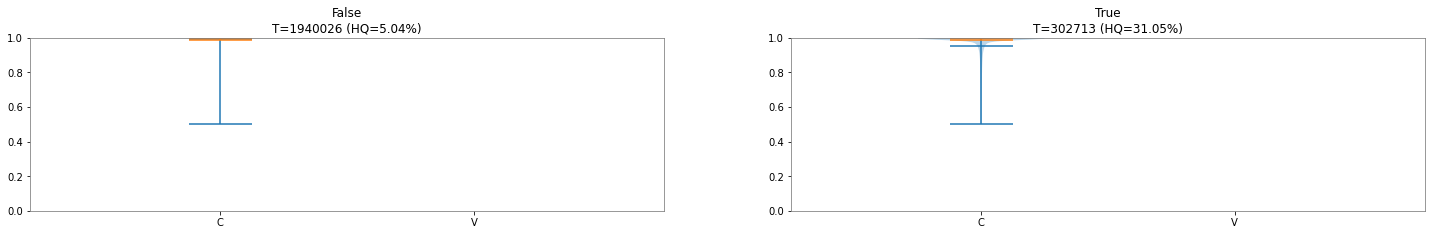

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [22]:
df_summary["confidence"].describe()

count    2.243540e+06
mean     9.873857e-01
std      5.571464e-02
min      5.000080e-01
25%      9.992324e-01
50%      9.997357e-01
75%      9.997793e-01
max      9.998216e-01
Name: confidence, dtype: float64

In [23]:
df_low_quality_threshold["prediction"].value_counts()

True     26495
False    25871
Name: prediction, dtype: int64

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


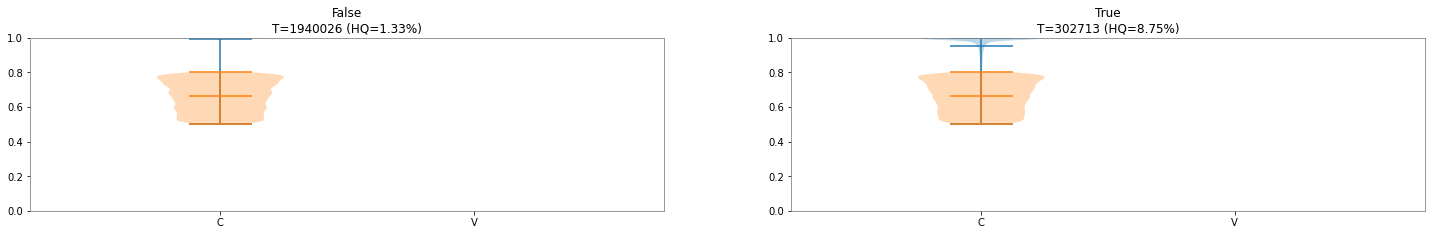

In [24]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [25]:
df_summary.shape

(2243540, 5)

In [26]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction               False           True
confidence count  1.940674e+06  302866.000000
           mean   9.927322e-01       0.953127
           std    4.254096e-02       0.100207
           min    5.000119e-01       0.500008
           25%    9.996506e-01       0.972660
           50%    9.997551e-01       0.996490
           75%    9.997813e-01       0.998473
           max    9.998216e-01       0.999223

In [27]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()


        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    
    
    
    dfs = [summary_df,  thresh_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  thresh\_count \\
prediction &            &               \\
\midrule
False      &    1940026 &         97744 \\
True       &     302713 &         93999 \\
Total      &    2242739 &        191743 \\
\bottomrule
\end{tabular}

CPU times: user 191 ms, sys: 2.53 ms, total: 194 ms
Wall time: 195 ms


,all_count,thresh_count
prediction,,
False,1940026,97744
True,302713,93999
Total,2242739,191743


In [28]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
False    98275
True     94129
dtype: int64

In [29]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [30]:

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")

df_high_quality_threshold.to_json(local_file_high_q_sample,  orient='records')
df_low_quality_threshold.to_json(local_file_low_q_sample,   orient='records')




In [31]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [32]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd
import tempfile
import transformers

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = ref_file_or_df
    marker_target_file = target_file_or_df

    
    if isinstance(ref_file_or_df, str):
        df_ref_marker = pd.read_json(marker_ref_file)
        df_target_marker =  pd.read_json(marker_target_file)
    else:
        df_ref_marker = marker_ref_file
        df_target_marker = marker_target_file
        
    t = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=None, stop_words=None, analyzer=lambda x: t.convert_ids_to_tokens(t([x], add_special_tokens=False)["input_ids"][0])[:512])
    comparison_result = comparer(df_ref_marker["abstract"].tolist(), df_target_marker["abstract"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [33]:
df_high_quality_threshold.shape

(192404, 9)

In [34]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


,abstract_id,abstract,false,true,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
3,20791839,Experiments were carried out in healthy male v...,0.999709,0.000291,False,0.999709,NaN,[0.9997089505195611],False,0.681347
9,20791874,"When breathing air, the average arterial oxyge...",0.999682,0.000318,False,0.999682,NaN,[0.9996817111968991],False,0.553678
5,20791870,All deaths from road accidents in certain area...,0.999766,0.000234,False,0.999766,NaN,[0.9997664093971251],False,0.550444
11,20791876,An increased incidence of previous infection w...,0.999792,0.000208,False,0.999792,NaN,[0.9997918009757991],False,0.426573
8,20791873,Over 500 human sera were tested by complement ...,0.999787,0.000213,False,0.999787,NaN,[0.9997867941856381],False,0.551481


<AxesSubplot:>

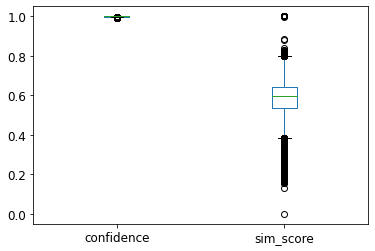

In [35]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

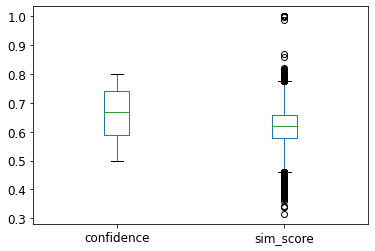

In [36]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [37]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["GHC","GHS", "GLC", "GLS"])


In [56]:
df_sim_score_high["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    192404.000000
mean        158.551787
std          76.634976
min           1.000000
25%         101.000000
50%         170.000000
75%         214.000000
max        1498.000000
Name: abstract, dtype: float64

In [53]:
df_sim_score_low["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    52366.000000
mean       208.163427
std         63.384462
min         25.000000
25%        165.000000
50%        204.000000
75%        247.000000
max       1214.000000
Name: abstract, dtype: float64

In [58]:
data_training_full_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    767.000000
mean     233.923077
std       69.000061
min       46.000000
25%      189.500000
50%      236.000000
75%      266.000000
max      730.000000
Name: abstract, dtype: float64

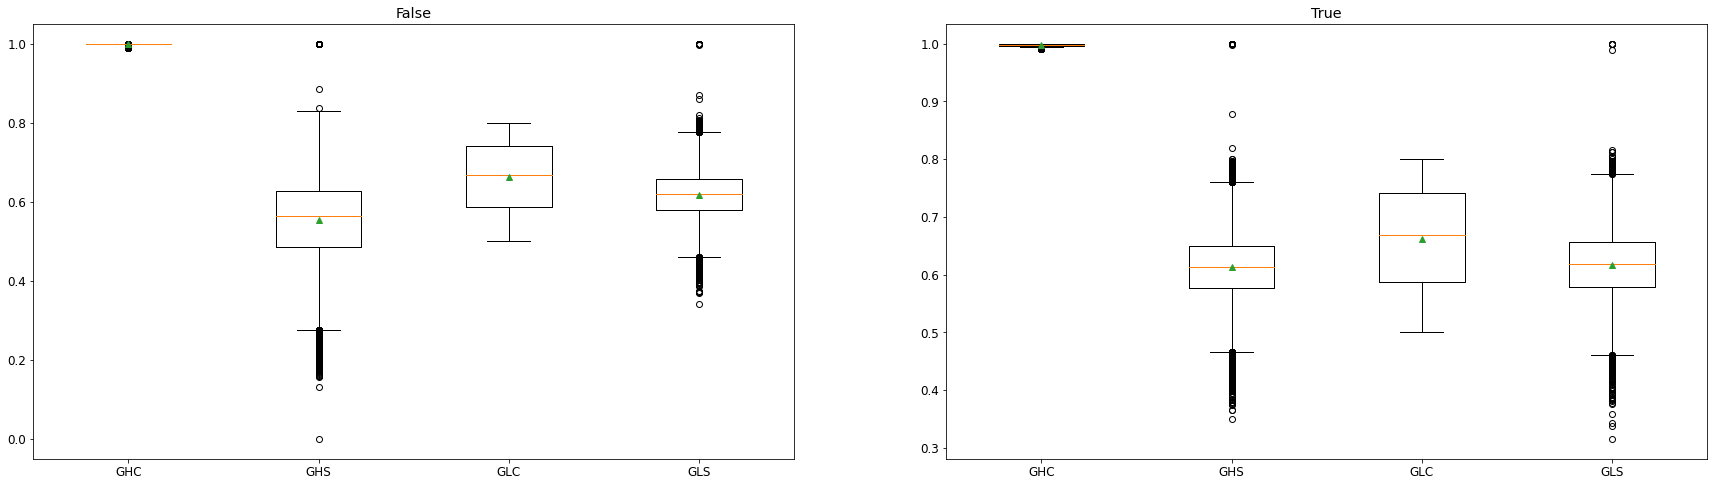

In [38]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [39]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         98275.0  0.999504  0.000982  0.990004  0.999676  0.999759   
True          94129.0  0.997292  0.002056  0.990000  0.996742  0.998232   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.999782  0.999816   98275.0  0.554427  0.104990  0.000000   
True        0.998651  0.999182   94129.0  0.612687  0.056285  0.350063   

                                               
                 25%       50%       75%  max  
prediction                                     
False       0.486784  0.563765  0.626835  1.0  
True        0.576269  0.614034  0.649758  1.0

In [40]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         25871.0  0.662076  0.087599  0.500012  0.587851  0.668109   
True          26495.0  0.662516  0.087562  0.500008  0.587060  0.669179   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.740121  0.799984   25871.0  0.616880  0.060068  0.340531   
True        0.740614  0.799999   26495.0  0.616652  0.059037  0.315338   

                                               
                 25%       50%       75%  max  
prediction                                     
False       0.578318  0.618966  0.657329  1.0  
True        0.578333  0.618642  0.656563  1.0

In [49]:
df_sim_score_high.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'Bcl-2 family proteins regulate a critical step in apoptosis referred to as mitochondrial outer membrane permeabilization (MOMP). Members of a subgroup of the Bcl-2 family, known as the BH3-only proteins, activate pro-apoptotic effectors (Bax and Bak) to initiate MOMP. They do so by neutralizing pro-survival Bcl-2 proteins and/or directly activating Bax/Bak. Bim and Bid are reported to be direct activators; however, here we show that BH3 peptides other than Bim and Bid exhibited various degrees of direct activation of the effector Bax or Bak, including Bmf and Noxa BH3s. In the absence of potent direct activators, such as Bim and Bid, we unmasked novel direct activator BH3 ligands capable of inducing effector-mediated cytochrome c release and liposome permeabilization, even when both Bcl-xL- and Mcl-1-type anti-apoptotic proteins were inhibited. The ability of these weaker direct activator BH3 peptides to cause MOMP correlated with that of the corresponding full-length proteins to indu

In [50]:
df_sim_score_low.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'The causative genetic defects of retinitis pigmentosa (RP) might be expected to affect the expression of messenger RNA in the retina. Total cellular RNA from retinas of normal and dystrophic individuals was therefore subjected to (i) in vitro translation and analysis by two-dimensional SDS polyacrylamide gel electrophoresis and (ii) Northern blot analysis using probes specific for ?-tubulin, interphotoreceptor retinoid-binding protein (IRBP) and glial fibrillary acidic protein (GFAP) mRNAs. Both methods revealed quantitative abnormalities in specific mRNA levels in RP. These differences appeared to reflect (i) the loss of photoreceptors in RP (decreased ?-tubulin and IRBP mRNA, and a reduced translation product comigrating with rhodopsin) and (ii) the proliferation of glial elements in the RP retinas (increased GFAP mRNA and its translation product). In addition, translation products of 21 and 39 kDa were consistently increased in RP retinas. These have not been previously detected in